<div class="alert alert-info">

Launch in Binder     [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master?filepath=doc%2FNotebooks%2Fexamples%2FCalifornia_Fires.ipynb)

<!-- Or launch an [Rstudio instance](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master?urlpath=rstudio?filepath=doc%2Fexamples%2FCalifornia_Fires.ipynb)
 -->
</div>

# California fires

In August 2020 in California, wildfires have burned more than [a million acres of land](https://edition.cnn.com/2020/10/06/us/gigafire-california-august-complex-trnd/index.html). 
The wildfires coinciding with record high temperature anomalies, see [August 2020 temperature anomaly](../California_august_temperature_anomaly.ipynb).
![California Temperature August 2020](../../../graphs/California_anomaly.png)


In this example, we evaluate the UNSEEN ensemble and show that there is a clear trend in temperature extremes over the last decades.  

### Retrieve data

<div class="alert alert-info">

Note
    
In this notebook you cannot use the python functions under Retrieve and Preprocess (they are here only for documentation on the entire workflow, see [retrieve](../1.Download/1.Retrieve.ipynb) if you want to download your own dataset. The resulting preprocessed dataset is provided so you can perform statistical analysis on the dataset and rerun the evaluation and examples provided.
    
</div>

The main functions to retrieve all forecasts (SEAS5) and reanalysis (ERA5) are `retrieve_SEAS5` and `retrieve_ERA5`. We want to download 2m temperature for August over California. By default, the hindcast years of 1981-2016 are downloaded for SEAS5. We include the years 1981-2020. The folder indicates where the files will be stored, in this case outside of the UNSEEN-open repository, in a 'California_example' directory. For more explanation, see [retrieve](../1.Download/1.Retrieve.ipynb).

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))
os.chdir(os.path.abspath('../../../'))

import src.cdsretrieve as retrieve
import src.preprocess as preprocess

import numpy as np
import xarray as xr

In [2]:
retrieve.retrieve_SEAS5(
    variables=['2m_temperature', '2m_dewpoint_temperature'],
    target_months=[8],
    area=[70, -130, 20, -70],
    years=np.arange(1981, 2021),
    folder='../California_example/SEAS5/')

In [3]:
retrieve.retrieve_ERA5(variables=['2m_temperature', '2m_dewpoint_temperature'],
                       target_months=[8],
                       area=[70, -130, 20, -70],
                       folder='../California_example/ERA5/')

### Preprocess

In the preprocessing step, we first merge all downloaded files into one xarray dataset, then take the spatial average over the domain and a temporal average over the MAM season. Read the docs on [preprocessing](../2.Preprocess/2.Preprocess.ipynb) for more info. 

In [4]:
SEAS5_California = preprocess.merge_SEAS5(folder ='../California_example/SEAS5/', target_months = [8])

Lead time: 07
6
5
4
3


And for ERA5:

In [5]:
ERA5_California = xr.open_mfdataset('../California_example/ERA5/ERA5_????.nc',combine='by_coords')

We calculate the standardized anomaly of the 2020 event and select the 2m temperature over the region where 2 standard deviations from the 1979-2010 average was exceeded, [see this page](../California_august_temperature_anomaly.ipynb). This is an area-weighed average, since grid cell area decreases with latitude, see [preprocess](../2.Preprocess/2.Preprocess.ipynb). 

In [6]:
ERA5_anomaly = ERA5_California['t2m'] - ERA5_California['t2m'].sel(time=slice('1979','2010')).mean('time')
ERA5_sd_anomaly = ERA5_anomaly / ERA5_California['t2m'].sel(time=slice('1979','2010')).std('time')

We use a land-sea mask to select land-only gridcells:

In [7]:
LSMask = xr.open_dataset('../California_example/ERA_landsea_mask.nc')
# convert the longitude from 0:360 to -180:180
LSMask['longitude'] = (((LSMask['longitude'] + 180) % 360) - 180)

In [8]:
area_weights = np.cos(np.deg2rad(ERA5_sd_anomaly.latitude))

ERA5_California_events = (
    ERA5_California['t2m'].sel(  # Select 2 metre temperature
        longitude = slice(-125,-100),    # Select the longitude
        latitude = slice(45,20)).        # And the latitude
    where(ERA5_sd_anomaly.sel(time = '2020').squeeze('time') > 2). ##Mask the region where 2020 sd >2. 
    where(LSMask['lsm'].sel(time = '1979').squeeze('time') > 0.5). #Select land-only gridcells
    weighted(area_weights).
    mean(['longitude', 'latitude']) #And take the mean
)

Plot the August temperatures over the defined California domain: 

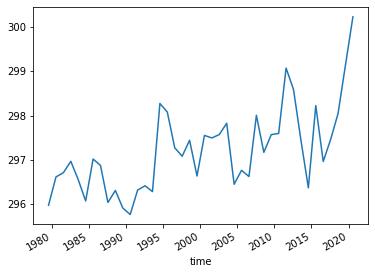

In [9]:
ERA5_California_events.plot()

Select the same domain for SEAS5 and extract the events.

In [10]:
SEAS5_California_events = (
    SEAS5_California['t2m'].sel(
        longitude = slice(-125,-100),    # Select the longitude
        latitude = slice(45,20)).        # And the latitude
    where(ERA5_sd_anomaly.sel(time = '2020').squeeze('time') > 2). #Mask the region where 2020 sd >2.
    where(LSMask['lsm'].sel(time = '1979').squeeze('time') > 0.5). #Select land-only gridcells
    weighted(area_weights).
    mean(['longitude', 'latitude']))

And here we store the data in the Data section so the rest of the analysis in R can be reproduced. 

In [11]:
SEAS5_California_events.rename('t2m').to_dataframe().to_csv('Data/SEAS5_California_events.csv')
ERA5_California_events.rename('t2m').to_dataframe().to_csv('Data/ERA5_California_events.csv')

### Evaluate


<div class="alert alert-info">

Note

From here onward we use R and not python!
    
We switch to R since we believe R has a better functionality in extreme value statistics. 

</div>

In [1]:
setwd('../../..')
getwd()

[1] "/lustre/soge1/projects/ls/personal/timo/UNSEEN-open"

In [2]:
SEAS5_California_events <- read.csv("Data/SEAS5_California_events.csv", stringsAsFactors=FALSE)
ERA5_California_events <- read.csv("Data/ERA5_California_events.csv", stringsAsFactors=FALSE)

## Convert Kelvin to Celsius
SEAS5_California_events$t2m <- SEAS5_California_events$t2m - 273.15
ERA5_California_events$t2m <- ERA5_California_events$t2m - 273.15

In [3]:
## Convert character time to Date format
ERA5_California_events$time <- lubridate::ymd(ERA5_California_events$time)
SEAS5_California_events$time <- lubridate::ymd(SEAS5_California_events$time)

*Is the UNSEEN ensemble realistic?* 

To answer this question, we perform three statistical tests: independence, model stability and model fidelity tests.  
These statistical tests are available through the [UNSEEN R package](https://github.com/timokelder/UNSEEN). 
See [evaluation](../3.Evaluate/3.Evaluate.ipynb) for more info.

In [4]:
require(UNSEEN)
require(ggplot2)

Loading required package: UNSEEN

Loading required package: ggplot2

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”


#### Timeseries
<a id='Timeseries'></a>

We plot the timeseries of SEAS5 (UNSEEN) and ERA5 (OBS) for the the Siberian Heatwave. 

You can call the documentation of the function with `?unseen_timeseries`

Warning message:
“Removed 4680 rows containing non-finite values (stat_boxplot).”


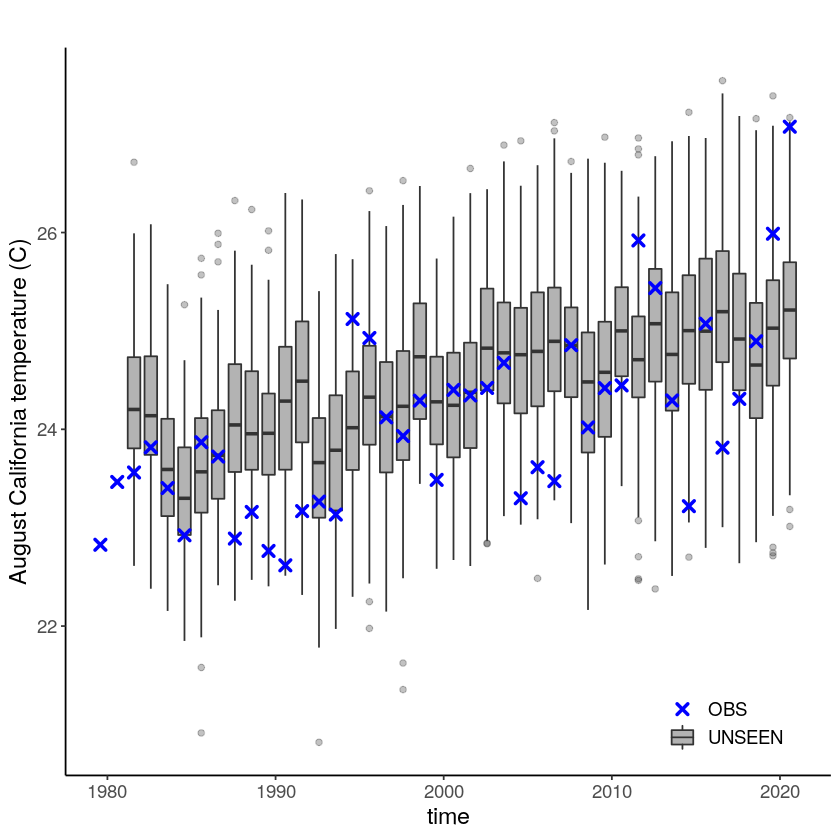

In [5]:
timeseries = unseen_timeseries(
    ensemble = SEAS5_California_events,
    obs = ERA5_California_events,
    ensemble_yname = "t2m",
    ensemble_xname = "time",
    obs_yname = "t2m",
    obs_xname = "time",
    ylab = "August California temperature (C)") 

timeseries + theme(text = element_text(size = 14))

The timeseries consist of **hindcast (years 1982-2016)** and **archived forecasts (years 2017-2020)**. The datasets are slightly different: the hindcasts contains 25 members whereas operational forecasts contain 51 members, the native resolution is different and the dataset from which the forecasts are initialized is different. 

**For the evaluation of the UNSEEN ensemble we want to only use the SEAS5 hindcasts for a consistent dataset**. Note, 2017 is not used in either the hindcast nor the operational dataset, since it contains forecasts both initialized in 2016 (hindcast) and 2017 (forecast), see [retrieve](../1.Download/1.Retrieve.ipynb).
We split SEAS5 into hindcast and operational forecasts:

In [6]:
SEAS5_California_events_hindcast <- SEAS5_California_events[
    SEAS5_California_events$time < '2017-02-01' &
    SEAS5_California_events$number < 25,]

SEAS5_California_events_forecasts <- SEAS5_California_events[
    SEAS5_California_events$time > '2017-02-01',]

And we select the same years for ERA5. 

In [7]:
ERA5_California_events_hindcast <- ERA5_California_events[
    ERA5_California_events$time > '1981-02-01' &
    ERA5_California_events$time < '2017-02-01',]

Which results in the following timeseries:

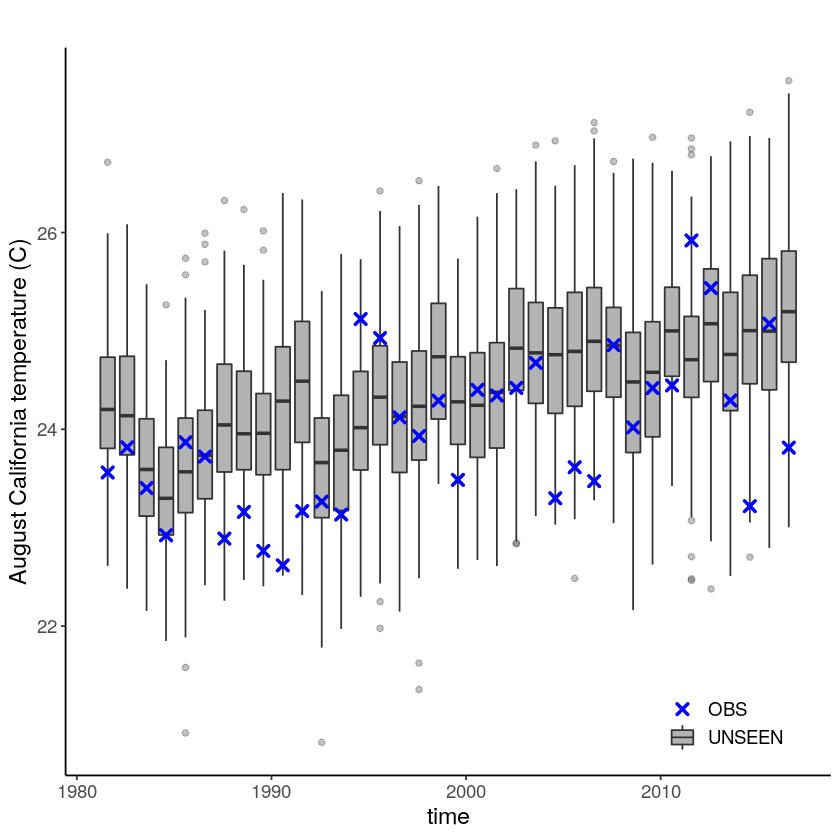

In [8]:
unseen_timeseries(
    ensemble = SEAS5_California_events_hindcast,
    obs = ERA5_California_events_hindcast,
    ensemble_yname = "t2m",
    ensemble_xname = "time",
    obs_yname = "t2m",
    obs_xname = "time",
    ylab = "August California temperature (C)") + 
theme(text = element_text(size = 14))

#### Evaluation tests
With the hindcast dataset we evaluate the independence, stability and fidelity. Here, we plot the results for the fidelity test, for more detail on the other tests see the [evaluation section](../3.Evaluate/3.Evaluate.ipynb). 

Warning message:
“Removed 1625 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1625 rows containing non-finite values (stat_boxplot).”


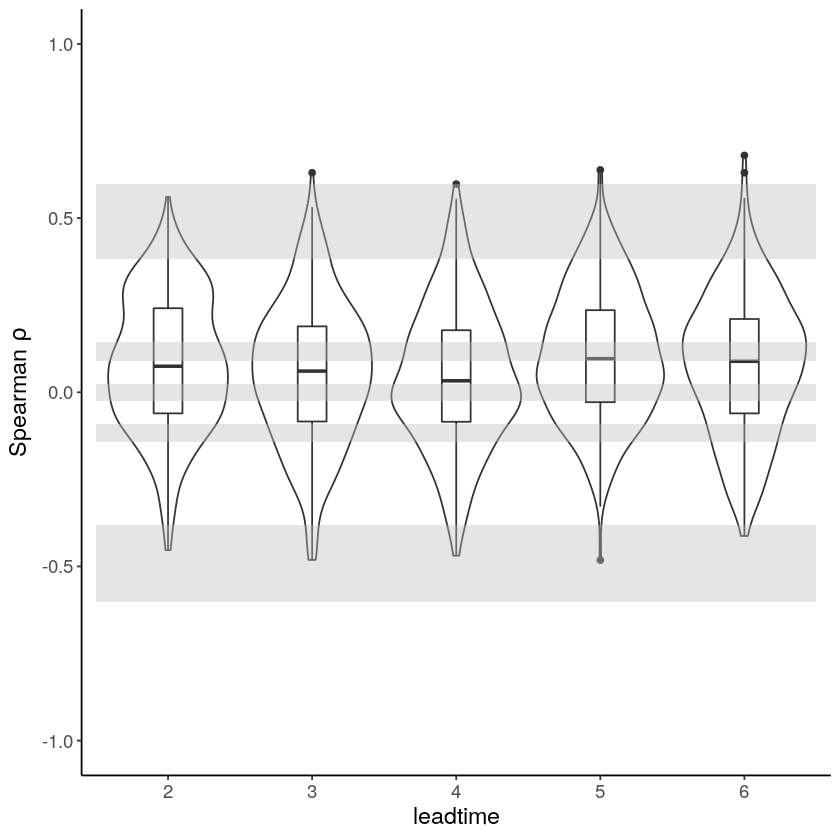

In [9]:
Independence_California = independence_test(
    ensemble = SEAS5_California_events_hindcast,
    var_name = "t2m"
    ) 

Independence_California +
    theme(text = element_text(size = 14))

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


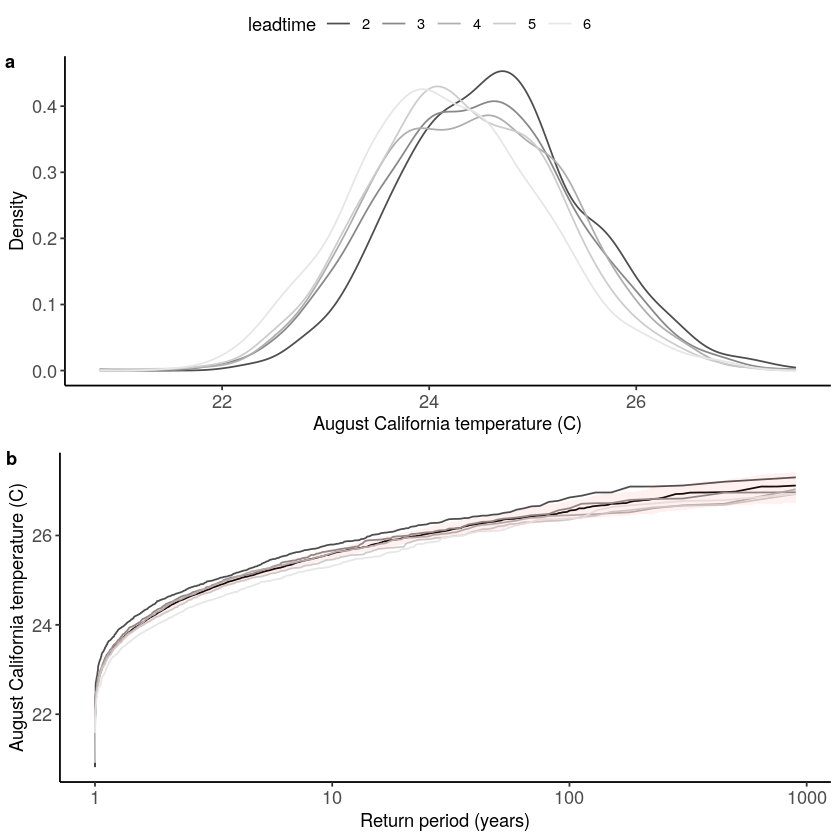

In [10]:
Stability_California = stability_test(
        ensemble = SEAS5_California_events_hindcast,
        lab = 'August California temperature (C)',
        var_name = 't2m'
    )
Stability_California


In [11]:
Stability_California = stability_test(
        ensemble = SEAS5_California_events_hindcast,
        lab = 'August temperature (C)',
        var_name = 't2m',
        fontsize = 10
    
    )
# ggsave(Stability_California,height = 120, width = 120, units = 'mm', filename = "graphs/California_stability.pdf")

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


The fidelity test shows us how consistent the model simulations of UNSEEN (SEAS5) are with the observed (ERA5). The UNSEEN dataset is much larger than the observed -- hence they cannot simply be compared. For example, what if we had faced a few more or a few less heatwaves purely by chance? 

This would influence the observed mean, but not so much influence the UNSEEN ensemble because of the large data sample. Therefore we express the UNSEEN ensemble as a range of plausible means, for data samples of the same length as the observed. We do the same for higher order [statistical moments](https://en.wikipedia.org/wiki/Moment_(mathematics)). 

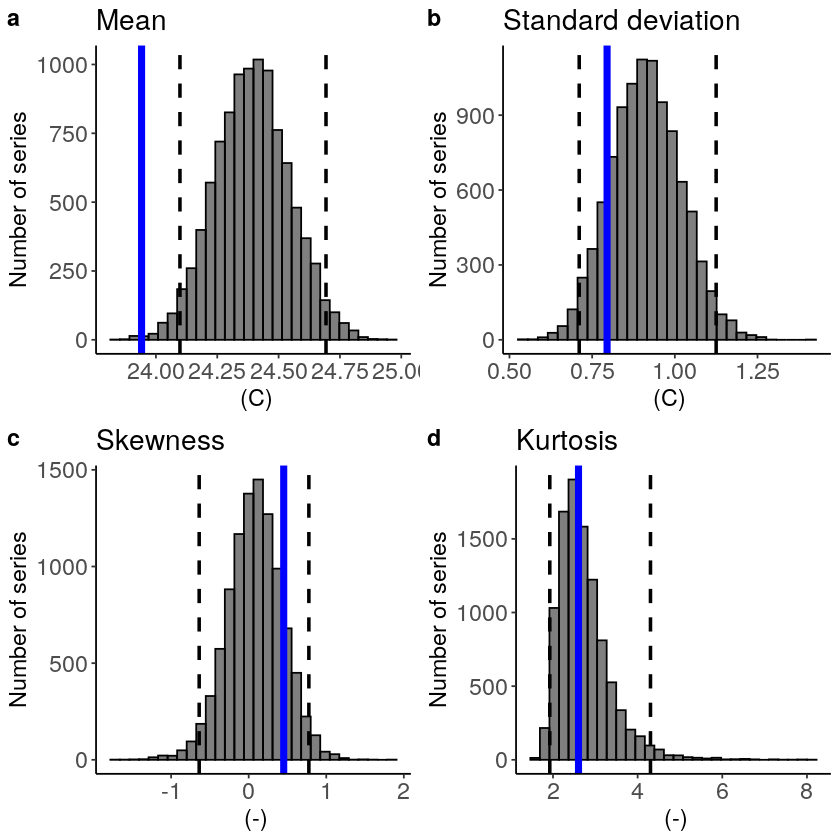

In [12]:
Fidelity_California = fidelity_test(
    obs = ERA5_California_events_hindcast$t2m,
    ensemble = SEAS5_California_events_hindcast$t2m,
    units = 'C',
    biascor = FALSE,
    fontsize = 14
)
Fidelity_California

The fidelity test shows that the mean of the UNSEEN ensemble is too low compared to the observed -- the blue line falls outside of the model range in a. To correct for this low bias, we can apply an additive bias correction, which only corrects the mean of the simulations. 

Lets apply the additive biascor:

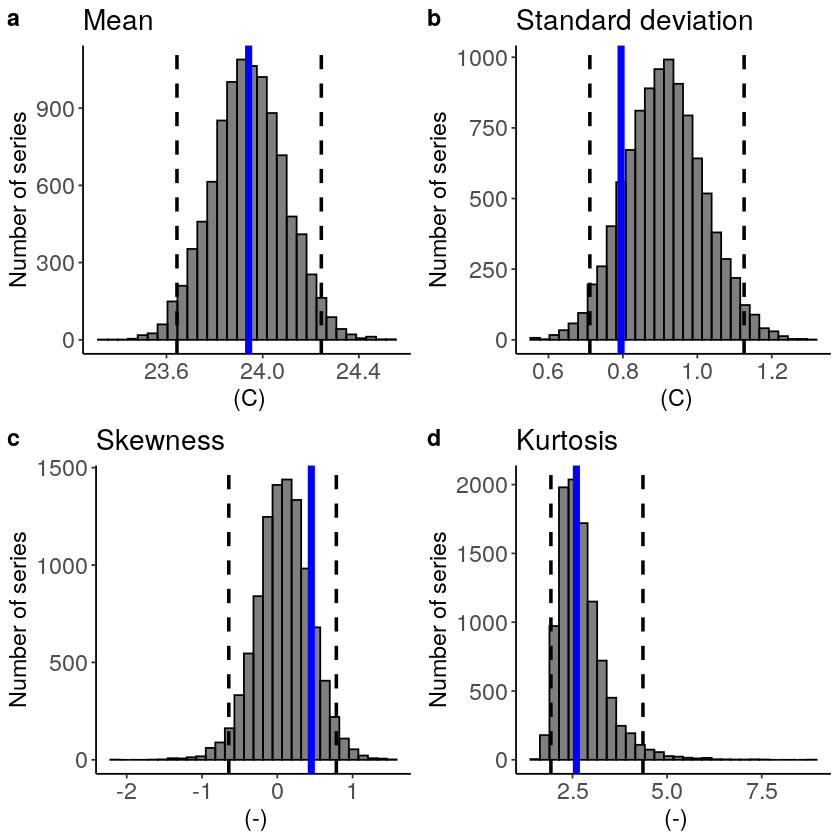

In [10]:
obs = ERA5_California_events_hindcast$t2m
ensemble = SEAS5_California_events_hindcast$t2m
ensemble_biascor = ensemble + (mean(obs) - mean(ensemble))

fidelity_test(
    obs = obs,
    ensemble = ensemble_biascor,
    units = 'C',
    biascor = FALSE,
    fontsize = 14
)

This shows us what we expected: the mean bias is corrected because the model simulations are shifted up (the blue line is still the same, the axis has just shifted along with the histogram), but the other statistical moments are the same. 

### Publication-ready plots
We combine the timeseries and the three evaluation plots in one plot for the manuscript. 
We want the font size to be 10 for all plots and we need to adjust the panel labels for the stability and fidelity plots. 
For the fidelity plot we also remove redundant ylabels and yticks. 

In [14]:
timeseries_font10 = timeseries + theme(text = element_text(size = 10))
Independence_font10 = Independence_California + theme(text = element_text(size = 10))
Stability_font10 = stability_test(
    ensemble = SEAS5_California_events_hindcast,
    lab = 'August temperature (C)',
    var_name = 't2m',
    fontsize = 10,
    panel_labels = c("c", "d")
)
Fidelity_font10 = fidelity_test(
    obs = ERA5_California_events_hindcast$t2m,
    ensemble = SEAS5_California_events_hindcast$t2m,
    ylab = '', 
    yticks = FALSE, 
    units = 'C',
    biascor = FALSE,
    fontsize = 10,
    panel_labels = c("e", "f", "g", "h")
)

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


Warning message:
“Removed 4680 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1625 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1625 rows containing non-finite values (stat_boxplot).”


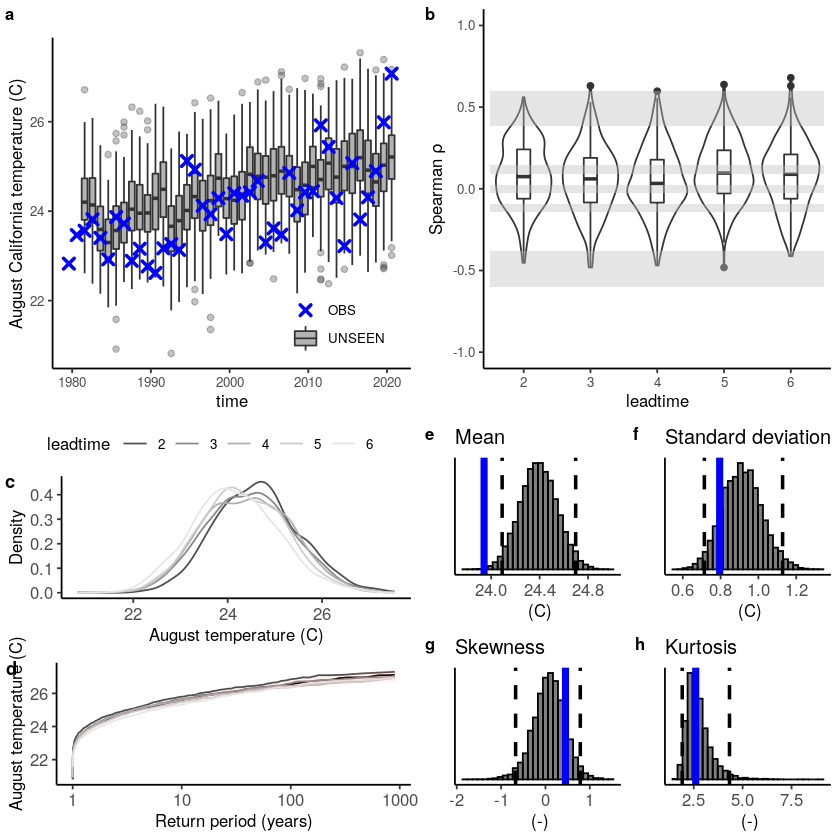

In [15]:
Evaluations = ggpubr::ggarrange(timeseries_font10,
                                Independence_font10,
                                Stability_font10,
                                Fidelity_font10,
                                labels = c("a","b", "", ""),
                                font.label = list(size = 10,
                                                  color = "black",
                                                  face = "bold",
                                                  family = NULL),
                                ncol = 2,
                                nrow = 2)
Evaluations
# ggsave(Evaluations,height = 180, width = 180, units = 'mm', filename = "graphs/California_evaluation_test2.pdf")

### Illustrate

Was there a trend in the temperature extremes over the last decades? Let's investigate!

First, we are loading the required extRemes package:

In [9]:
require('extRemes')

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




We also source some R code to make the unseen-trends plots. These functions were written for this case study and we cannot ensure robustness to other case studies. 

In [24]:
source('src/evt_plot.r')

We use ERA5 events from 1981 to match the starting date of SEAS5, which we call 'obs'. In addition, we use the bias corrected UNSEEN ensemble with ld 6 removed. We remove the first two years from ERA5 and we remove lead time 6 from the SEAS5 ensemble:

In [10]:
obs <- ERA5_California_events[
    ERA5_California_events$time > '1981-02-01',]

UNSEEN_bc <- SEAS5_California_events[SEAS5_California_events$leadtime < 6 &
                                     SEAS5_California_events$number < 25,]

And then we correct the SEAS5 temperature bias using a mean adjustment calculated over the hindcast period.  

In [11]:
UNSEEN_bc$t2m <- (UNSEEN_bc$t2m +
                  mean(ERA5_California_events_hindcast$t2m) - mean(SEAS5_California_events_hindcast$t2m)
                               )
str(UNSEEN_bc)

'data.frame':	4000 obs. of  4 variables:
 $ leadtime: int  2 2 2 2 2 2 2 2 2 2 ...
 $ time    : Date, format: "1981-08-01" "1981-08-01" ...
 $ number  : int  0 1 2 3 4 5 6 7 8 9 ...
 $ t2m     : num  23 24.8 23.2 23.9 24.6 ...


Lets plot the data to see whats going on

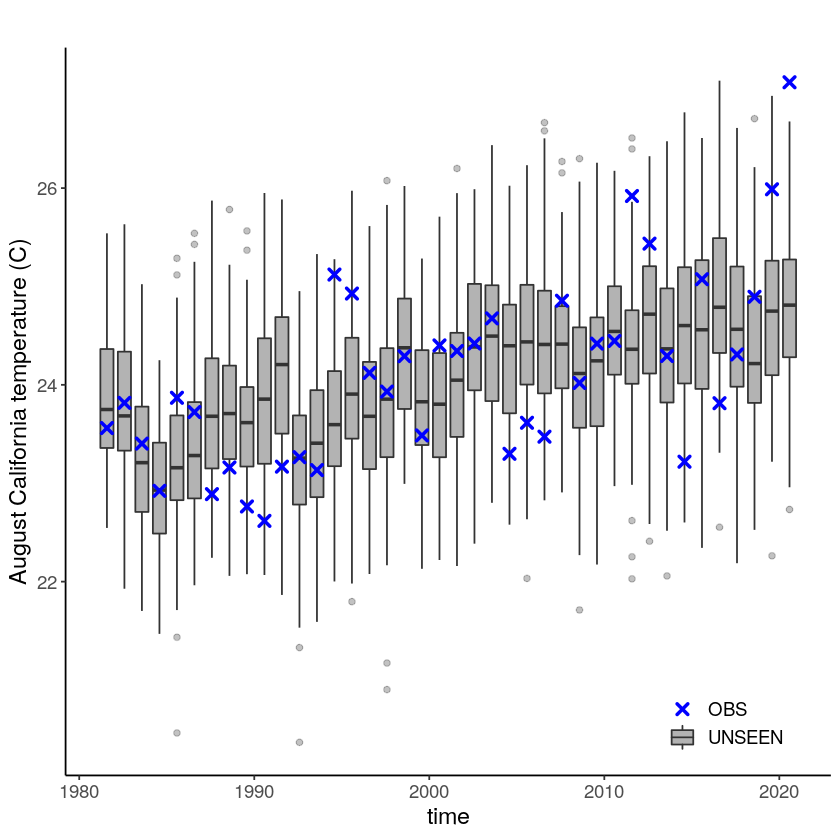

In [12]:
timeseries = unseen_timeseries(
    ensemble = UNSEEN_bc,
    obs = obs,
    ensemble_yname = "t2m",
    ensemble_xname = "time",
    obs_yname = "t2m",
    obs_xname = "time",
    ylab = "August California temperature (C)") 

timeseries + theme(text = element_text(size = 14))

We apply extreme value theory to analyze the likelihood and trend of the temperature extremes. There are different extreme value distributions that can be used to fit to the data. First, we fit a stationary Gumbel and a GEV distribution (including shape parameter) to the observed extremes, which shows that GEV better describes the data with a p-value of 0.0001 using the LR-test. Then we fit a nonstationary GEV distribution to the observed temperatures and show that this best fits the data with a very small p-value of 3.633e-05 as compared to the stationary distribution (much below 0.05 based on 5% significance with the likelihood ratio test).

In [13]:
## Fit stationary distributions
fit_obs_Gumbel <- fevd(x = obs$t2m,
                    type = "Gumbel"
                   )
fit_obs_GEV <- fevd(x = obs$t2m,
                    type = "GEV"
                   )
## And the nonstationary distribution
fit_obs_GEV_nonstat <- fevd(x = obs$t2m,
                            type = "GEV",
                            location.fun = ~ c(1:length(obs$time)), ##Fitting the gev with a location and scale parameter linearly correlated to the covariate (years)
                            scale.fun = ~ c(1:length(obs$time)), 
                            use.phi = TRUE
                           )
#And test the fit
##1. Stationary Gumbel vs stationary GEV
lr.test(fit_obs_Gumbel, fit_obs_GEV_nonstat) 
##2. Stationary GEV vs Nonstationary GEV
lr.test(fit_obs_GEV, fit_obs_GEV_nonstat)


	Likelihood-ratio Test

data:  obs$t2mobs$t2m
Likelihood-ratio = 20.446, chi-square critical value = 7.8147, alpha =
0.0500, Degrees of Freedom = 3.0000, p-value = 0.0001372
alternative hypothesis: greater



	Likelihood-ratio Test

data:  obs$t2mobs$t2m
Likelihood-ratio = 20.446, chi-square critical value = 5.9915, alpha =
0.0500, Degrees of Freedom = 2.0000, p-value = 3.633e-05
alternative hypothesis: greater


For the unseen ensemble this analysis is slightly more complicated since we need a covariate that has the same length as the ensemble:

In [14]:
#Create the ensemble covariate
year_vector = as.integer(format(UNSEEN_bc$time, format="%Y"))
covariate_ens = year_vector - 1980 

# Fit the stationary distribution
fit_unseen_GEV <- fevd(x = UNSEEN_bc$t2m,
                       type = 'GEV',
                       use.phi = TRUE)

fit_unseen_Gumbel <- fevd(x = UNSEEN_bc$t2m,
                          type = 'Gumbel',
                          use.phi = TRUE)

# Fit the nonstationary distribution
fit_unseen_GEV_nonstat <- fevd(x = UNSEEN_bc$t2m,
                               type = 'GEV',
                               location.fun = ~ covariate_ens, ##Fitting the gev with a location and scale parameter linearly correlated to the covariate (years)
                               scale.fun = ~ covariate_ens, 
                               use.phi = TRUE)

And the likelihood ratio test tells us that the nonstationary GEV distribution is the best fit, both p-values < 2.2e-16:

In [15]:
#And test the fit
##1. Stationary Gumbel vs stationary GEV
lr.test(fit_unseen_Gumbel,fit_unseen_GEV) 
##2. Stationary GEV vs Nonstationary GEV
lr.test(fit_unseen_GEV, fit_unseen_GEV_nonstat) 


	Likelihood-ratio Test

data:  UNSEEN_bc$t2mUNSEEN_bc$t2m
Likelihood-ratio = 568.39, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value < 2.2e-16
alternative hypothesis: greater



	Likelihood-ratio Test

data:  UNSEEN_bc$t2mUNSEEN_bc$t2m
Likelihood-ratio = 945.52, chi-square critical value = 5.9915, alpha =
0.0500, Degrees of Freedom = 2.0000, p-value < 2.2e-16
alternative hypothesis: greater


We plot unseen trends in 100-year extremes. The function `unseen-trends1` fits the trend for a selected return period (rp) for both the observed and ensemble datasets. For the observed dataset, the year 2020 was not used in the fit. For more info on the UNSEEN-trend method see [this paper](https://doi.org/10.1038/s41612-020-00149-4) and for more details on the results, see section 3.2 of the [open workflow paper](http://eartharxiv.org/repository/view/2681/). The function  was written for this case study in specific, and we cannot ensure robustness to other case studies. 

In [19]:
year_vector = as.integer(format(UNSEEN_bc$time, format="%Y"))
covariate_ens = year_vector - 1980 

Trend_2year <- unseen_trends1(ensemble = UNSEEN_bc$t2m,
                     x_ens = year_vector,
                     x_obs = 1981:2020,
                     rp = 2,
                     obs = obs$t2m,
                     covariate_ens = covariate_ens,
                     covariate_obs = c(1:(length(obs$time)-1)),
                     covariate_values = c(1:length(obs$time)),
                     GEV_type = 'GEV',
                     ylab = 'August temperature (C)',
                     title = '2-year') +
ylim(c(20,28.5))

Trend_100year <- unseen_trends1(ensemble = UNSEEN_bc$t2m,
                     x_ens = year_vector,
                     x_obs = 1981:2020,
                     rp = 100,
                     obs = obs$t2m,
                     covariate_ens = covariate_ens,
                     covariate_obs = c(1:(length(obs$time)-1)),
                     covariate_values = c(1:length(obs$time)),
                     GEV_type = 'GEV',
                     ylab = '',
                     title = '100-year') +
ylim(c(20,28.5))

We combine the two plots:

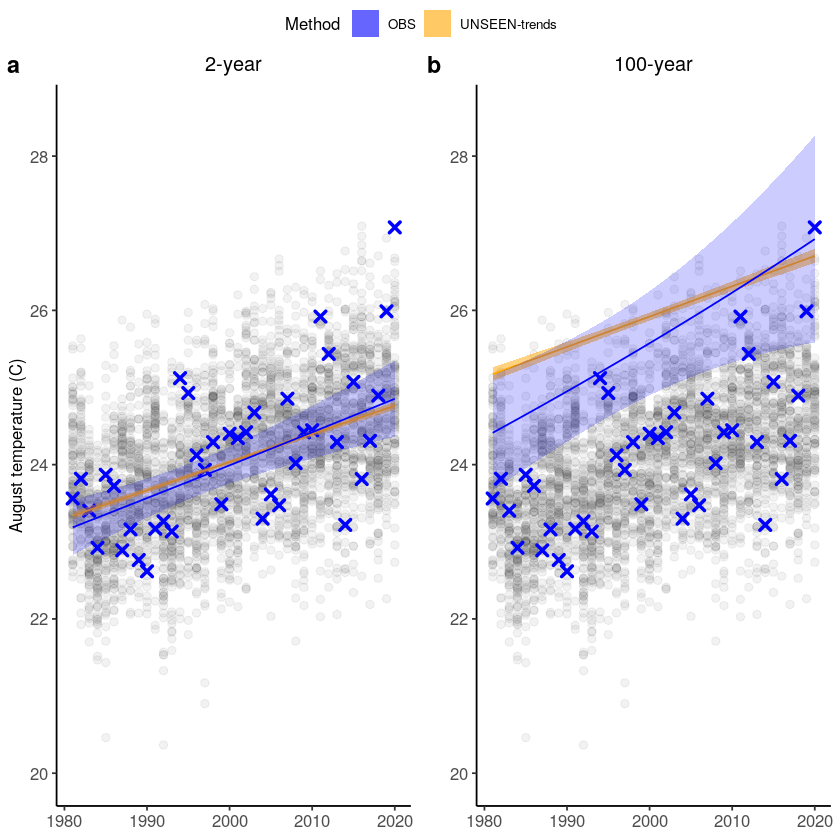

In [21]:
ggpubr::ggarrange(Trend_2year,Trend_100year,
                  labels = c("a","b"),
                  common.legend = TRUE,
                  font.label = list(size = 14,
                                    color = "black",
                                    face = "bold",
                                    family = NULL),
                  ncol = 2,
                  nrow = 1) #+
# ggsave(height = 100, width = 180, units = 'mm', filename = "graphs/California_trends.png")

There is a clear trend in the temperature extremes over last 40 years. How has this trend influenced the likelihood of occurrence of the 2020 event? The function `unseen_trends2` plots the extreme value distributions for the 'year' covariate 1981 and 2020. There is a clear difference -- the distribution for 1981 does not even reach the 2020 event. See section 3.2 of the [open workflow paper](http://eartharxiv.org/repository/view/2681/) for more details on this exciting but scary result! Note that also this function was written for this case study in specific, and we cannot ensure robustness to other case studies. 

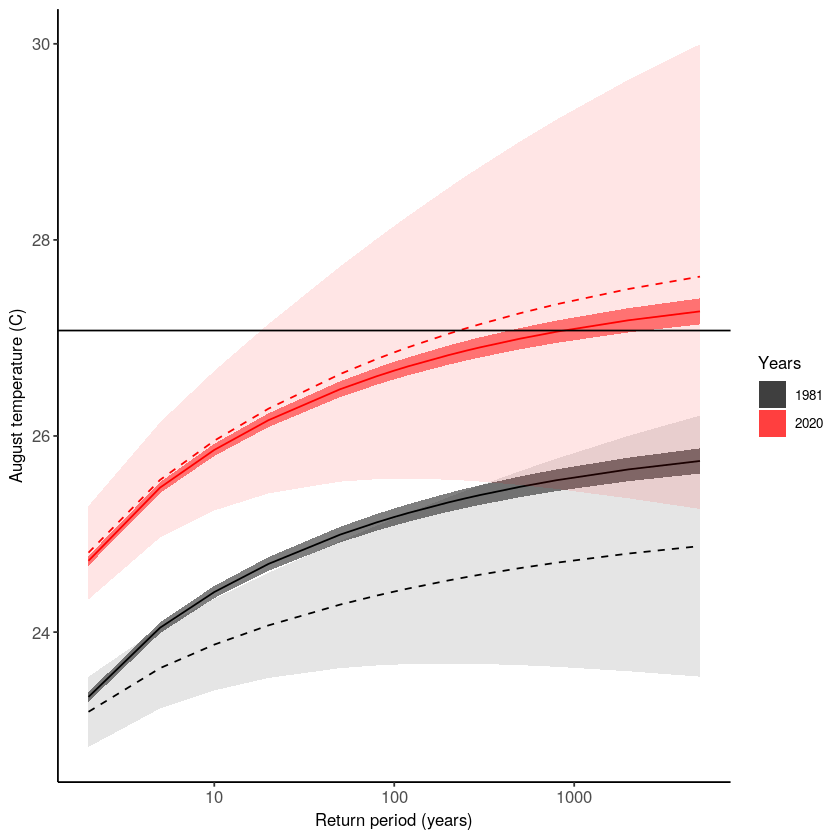

In [25]:
p2 <- unseen_trends2(ensemble = UNSEEN_bc$t2m,
                    obs = obs[1:(length(obs$time)-1),]$t2m,
                    covariate_ens = covariate_ens,
                    covariate_obs = c(1:(length(obs$time)-1)), 
                    GEV_type = 'GEV', 
                    ylab = 'August temperature (C)')

Distributions = p2 + geom_hline(yintercept = obs[obs$time == '2020-08-01',]$t2m) #+ 
Distributions

Let's make a publication-ready plot by combining the above figures. 

In [135]:
Trends = ggpubr::ggarrange(Trend_2year,Trend_100year,
                  labels = c("a","b"),
                  common.legend = TRUE,
                  font.label = list(size = 10,
                                    color = "black",
                                    face = "bold",
                                    family = NULL),
                  ncol = 2,
                  nrow = 1) 


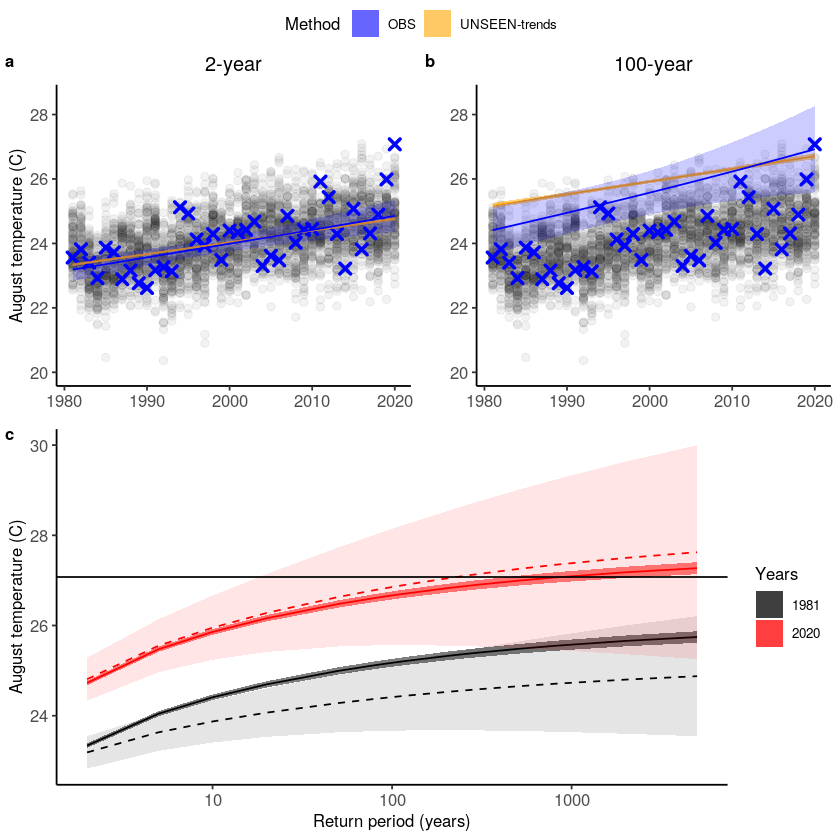

In [136]:
ggpubr::ggarrange(Trends,Distributions,
                  labels = c("","c"),
                  font.label = list(size = 10,
                                    color = "black",
                                    face = "bold",
                                    family = NULL),
                  ncol = 1,
                  nrow = 2) +
ggsave(height = 180, width = 180, units = 'mm', filename = "graphs/California_trends2.pdf")

**Applications:**

We have seen the worst fire season over California in 2020. Such fires are likely part of a chain of impacts, from droughts to heatwaves to fires, with feedbacks between them. Here we assess August temperatures and show that the 2020 August average temperature was very anomalous. We furthermore use SEAS5 forecasts to analyze the trend in rare extremes. Evaluation metrics show that the model simulations have a high bias, which we correct for using an additive bias correction. UNSEEN trend analysis shows a clear trend over time, both in the model and in the observed temperatures. Based on this analysis, temperature extremes that you would expect to occur once in 1000 years in 1981 might occur once in <10 years at present (2020).

**Note**

Our analysis shows the results of a *linear* trend analysis of August temperature averages over 1981-2020. Other time windows, different trends than linear, and spatial domains could (should?) be investigated, as well as drought estimates in addition to temperature extremes.  